In [134]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import math

from sympy import Point2D

In [302]:
h = 620
w = 620

def PxltoCoord(x, y, zoom, cntr_lat, cntr_lon):
    parallelMultiplier = math.cos(cntr_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = cntr_lat - degreesPerPixelY * (y - h / 2)
    pointLng = cntr_lon + degreesPerPixelX * (x - w / 2)

    return [float(pointLat), float(pointLng)]


# Because of non linear transformation (going from pixel to coordinates), function has to be solved for X and Y
def CoordToPixel(pointLat, pointLon, test_lat, test_lon, zoom):
    parallelMultiplier = math.cos(test_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier

    Y = (test_lat - pointLat) / degreesPerPixelY + 0.5 * h
    X = (pointLon - test_lon) / degreesPerPixelX + 0.5 * w
    return X, Y

In [303]:
def find_specific_lookup(data, search_image, template_name):
    for entry in data:
        if entry["search_image"] == search_image:
            for template in entry["templates"]:
                if template["template"] == template_name:
                    return template
    return None

In [304]:
from matplotlib import image as mpimg

#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/train_template_matching.json')

#source and query images
s_img_path = os.path.join(base_path, 'Data/map_train/51.99908_4.373749.png')
q_img_path = os.path.join(base_path, 'Data/train_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)

with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            images.append([q_img[:, :, :3], s_img[:,:,:3]]) 
            gps = find_specific_lookup(label, '51.99908_4.373749.png', file)
            
            templates.append((q_img[:, :, :3], gps))

In [305]:
def extract_features_for_templates(templates, source_image):
    feature_list = []
    label_list = []
    
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = query_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])
        
        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    max_len = max(len(features) for features in feature_list)
    # max_len = 468
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)

In [232]:
def extract_keypoints(templates, source_image):
    feature_list = []
    label_list = []
    src_flat = []
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = dst_pts
        # dst_flat = dst_pts.flatten()
        # input_features = np.concatenate([src_flat, dst_flat])
        # 
        # # Append to feature list
        # feature_list.append(input_features)
        # label_list.append(gps_pixel)  # GPS coordinates of this template image
    # max_len = max(len(features) for features in feature_list)
    # # max_len = 468
    # padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return src_flat

In [233]:
###### DB SCAN

In [306]:
X_train, y_train = extract_features_for_templates(templates, s_img)

In [234]:
keypoints_train = extract_keypoints(templates, s_img)

66


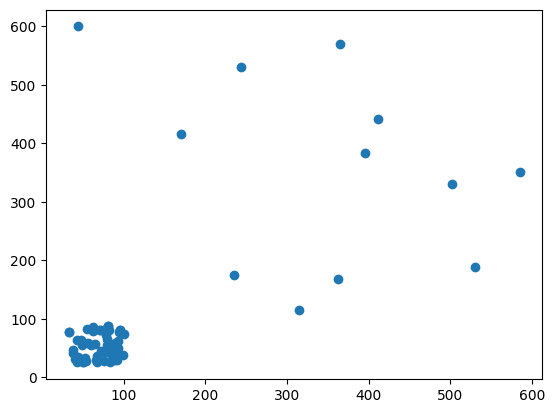

In [250]:
print(len(keypoints_train))

plt.scatter(keypoints_train[:, 0], keypoints_train[:, 1])

In [298]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

def cluster(keypoints_train):

    #keypoints_train = extract_keypoints(templates, s_img)
    db = DBSCAN(eps=0.5, min_samples=5).fit(keypoints_train/620)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # print(n_clusters_)
    return labels

In [299]:
def retrieve_relevant_points(keypoints_train, labels):
    cluster = []
    for i in range(len(keypoints_train)):
        if labels[i] == 0:
            cluster.append(keypoints_train[i])
    return cluster

In [300]:
def get_pixel_average(coords):
    return np.average(coords, axis=0)

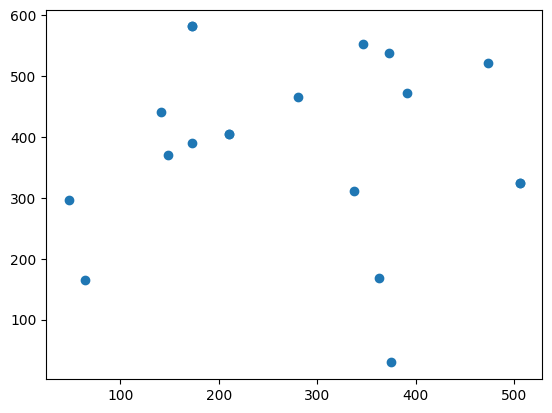

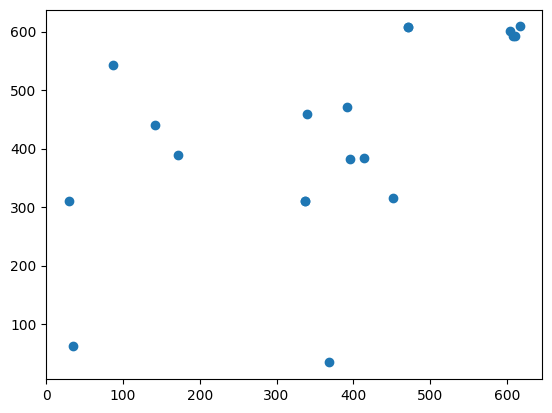

KeyboardInterrupt: 

In [308]:
from haversine import haversine, Unit

distance = 0
for temp in templates:
    keys = extract_keypoints([temp], s_img)
    labels = cluster(keys)
    points = retrieve_relevant_points(keys, labels)
    avg_points = get_pixel_average(points)
    
    predicted_coords = PxltoCoord(avg_points[0], avg_points[1], 15, 51.999080, 4.373749)
    # print(temp[1]['gps_coords'])
    actual_coords = temp[1]['gps_coords']
    distance += haversine(predicted_coords, actual_coords, unit=Unit.METERS)
    if haversine(predicted_coords, actual_coords, unit=Unit.METERS) > 500:
        plt.scatter(keys[:, 0], keys[:, 1])
        plt.show()
        
    # print(haversine(predicted_coords, actual_coords, unit=Unit.METERS))
print(distance/len(templates))
    

In [309]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop, Adam

# Define the model
def build_model(input_size):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(2)  # Predict latitude and longitude
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.85),  # You can tune the learning rate
              loss='mean_squared_error')
    return model


In [208]:
print(X_train.shape[1])

504


In [310]:
# Initialize and train the model
model = build_model(X_train.shape[1])
model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2)


Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 74401.3438 - val_loss: 27930.4766
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11586.2129 - val_loss: 20899.2910
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6651.0288 - val_loss: 15670.8896
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4252.8174 - val_loss: 10265.4619
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3439.8110 - val_loss: 7575.9058
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2525.8145 - val_loss: 6734.1548
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2029.8589 - val_loss: 7275.3618
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1628.6119 - val_loss: 5300.8921
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1083.0219 - val_loss: 6805.4204
Epoch 10/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 947.4605 - val_loss: 7008.8481
Epoch 11/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 957.5898 - val_loss: 67

In [316]:
#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/test_template_matching.json')

#source and query images
s_img_path = os.path.join(base_path, 'Data/map_train/51.99908_4.373749.png')
q_img_path = os.path.join(base_path, 'Data/test_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)

with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            images.append([q_img[:, :, :3], s_img[:,:,:3]]) 
            gps = find_specific_lookup(label, '51.99908_4.373749.png', file)
            
            templates.append((q_img[:, :, :3], gps))

In [317]:
def extract_features_for_test(templates, source_image):
    feature_list = []
    label_list = []
    
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        good_matches = good_matches[:100]
        # Extract matched keypoints
        src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = src_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])
        
        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    max_len = max(len(features) for features in feature_list)
    # max_len = 504
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)

In [318]:
X_test, y_test = extract_features_for_test(templates, s_img)

In [319]:
print(X_test.shape, X_train.shape)

(300, 400) (1000, 400)


In [320]:
from haversine import haversine, Unit
distance = 0
for i, test_input in enumerate(X_test):
    y_trinna = PxltoCoord(y_test[i][0], y_test[i][1], 15, 51.999080, 4.373749)
    # print(test_input.shape)
    point2 = model.predict(test_input.reshape(1, -1))
    # print(point2)
    point2 = PxltoCoord(point2[0][0], point2[0][1], 15, 51.999080, 4.373749)
    # print(point2)
    # print(point2)
    distance += haversine(y_trinna, point2, unit=Unit.METERS)
print(len(X_test))
print(distance/len(X_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━